# Случайные процессы. Прикладной поток.
## Практическое задание 7

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 7"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* При проверке могут быть запущены функции, которые отвечают за генерацию траекторий винеровского процесса.

------------------

In [626]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.linear_model import LinearRegression
import pandas as pd

## Регрессия на гауссовских процессах

Напомним задачу регрессии. Пусть имеется некоторая функциональная зависимость $y = f(x)$. Для ее оценки проводится серия испытаний в точках $x_1, ..., x_n$, в которых получаются значения $Y_i = f(x_i) + \varepsilon_i$, где $\varepsilon_i$ --- случайная ошибка измерений. Задача состоит в том, чтобы по этим наблюдениям оценить зависимость $f$. В курсе статистики мы рассматривали случай линейных функций. Теперь рассмотрим случай, когда $f$ является траекторией некоторого стационарного гауссовского процесса.

*Внимание!* Далее происходит смена обозначений на принятые в случайных процессах. Буква $x$ меняется на $t$, а буква $y$ меняется на $x$.

Пусть $X = (X_t, t \in \mathbb{R})$ --- стационарный гауссовский процесс с нулевой функцией среднего и ковариационной функцией $R(t) = cov(X_t, X_0)$. Даны его измерения $x_1, ..., x_n$ в моменты времени $t_1, ..., t_n$ соответственно. Тогда условное распределение $X_t$ при условии $X_{t_1} = x_1, ..., X_{t_n} = x_n$ является нормальным со средним $r^TC^{-1}\overrightarrow{x}$ и дисперсией $R(0) - r^TC^{-1}r$, где $C=\left(R(t_i - t_j)\right)_{i,j}$, $r=\left(R(t - t_1), ..., R(t - t_n)\right)^T$, $\overrightarrow{x}=\left(x_1, ..., x_n\right)^T$.


Байесовской оценкой общего вида значения процесса в момент времени $t$ является условное распределение $X_t$ при условии $...$.
В качестве точечной оценки обычно берут условное математическое ожидание $\mathsf{E}\left(X_t \left| X_{t_1} = x_1,\ ...,\ X_{t_n} = x_n \right. \right)$.
Кроме того, для каждого $t$ можно построить доверительный интервал для величины $X_t$, зная условную дисперсию.

Предположим, что для каждого $t$ построен доверительный интервал для $X_t$ уровня доверия 0.95. Верно ли, что $\mathsf{P}(\exists t: \text{истинное значение $X_t$ не попало в свой доверительный интервал}) \leqslant 0.05$?

**Ответ:** из определения доверительного интервала следует $\forall t:\mathsf{P}(\text{истинное значение $X_t$ не попало в свой доверительный интервал}) \leqslant 0.05$
, но в общем случае не следует указанное выше условие. Следует, если, например, $X_t = \xi_t \sim N(0,1)$ и $\xi_t$ независимы, то следует; когда $X_t = t$ - не следует.

Напишите класс регрессии на гауссовских процессах.
Интерфейс похож на интерфейс библиотеки `scikit-learn`.

Наш класс будет работать для времени из $\mathbb{R}^d$, а не $\mathbb{R}$.
Почему так можно сделать на основе решенной задачи?

**Ответ:** мы нигде не использовали тот факт, что X  - (одномерный) случайный процесс, а не случайное поле. 

При написании класса пользуйтесь `numpy.matrix` для работы с матрицами, либо операцией `@` для объектов `numpy.array`.

In [627]:
class GaussianProcessRegression:
    
    def __init__(self, cov_function):
        self.cov_function = cov_function
    
    
    def fit(self, T, X):
        ''' "Обучение" модели регрессии.
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые проведены измерения
                X --- np.array, размерность n: полученные значения процесса
        '''
        
        # <Тут посчитайте все, что зависит только от T и X>
        if (len(T.shape) == 1):
            T.reshape((T.shape[0]))
        self.T = T
        self.X = X
        
        self.cov_function_vectorized = self.cov_function
        #self.cov_function_vectorized = (
        #    np.vectorize(self.cov_function, signature="(n)->()")
        #)
        # https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array
        
        self.cov_function_at_zero = self.cov_function(np.zeros(T.shape[1]))
        
        C = np.array([
            [T[i] - T[j] for j in range(T.shape[0])]
                for i in range(T.shape[0])
        ])
        C = self.cov_function_vectorized(C)
        
        self.C_inversed = np.linalg.inv(C)
        
        return self
        
        
    def predict(self, T):
        ''' Оценка значения процесса. 
                T --- np.array, размерность (n, d): моменты времени, 
                      в которые нужно оценить значения. 
                
            Возвращает:
                values --- np.array, размерность n: предсказанные 
                           значения процесса
                sigma --- np.array, размерность n: соответствующая дисперсия
        '''
        # Дисперсию логичнее было бы назвать sigma2
        
        # <Вычисления, постарайтесь без циклов>
        values = []
        sigma = []
        # print(T.shape, self.T.shape)
        for t in T:
            r = self.cov_function_vectorized(t - self.T)
            values.append(r.T @ self.C_inversed @ self.X.T)
            sigma.append(self.cov_function_at_zero - r.T @ self.C_inversed @ r)
    
        return np.array(values), np.array(sigma)

Зададим какую-нибудь простую функцию $f(t)$

In [628]:
def calc_f(t, a=0.2, b=0.5, c=2):
    return np.log(1 + t) + a * t + b * np.sin(c * t)

И ковариационную функцию
$$R(t) = a\ exp\left(\frac{\left|\left| t \right|\right|^2} {2s^2} \right),$$

* $t \in \mathbb{R}^d$
* $a, s > 0$ --- параметры

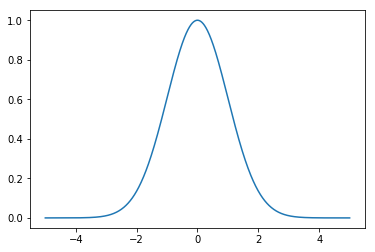

In [629]:
def exp_cov(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2))

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov(grid.reshape((-1, 1))))
plt.show()

Проведем эксперименты.
Зададим гауссовский процесс $(X_t, t\in\mathbb{R})$ в виде $X_t = f(t) + \sigma\varepsilon_t$, где $(\varepsilon_t, t\in\mathbb{R})$ --- гауссовский белый шум, то есть все $\varepsilon_t$ независимы и имеют стандартное нормальное распределение.

В качестве моментов времени $t_1, ..., t_n$ гененируем несколько точек на прямой.
Для начала возьмем $\sigma=0$, что соответствует отсутствию погрешности измерений.
Выполните код ниже.

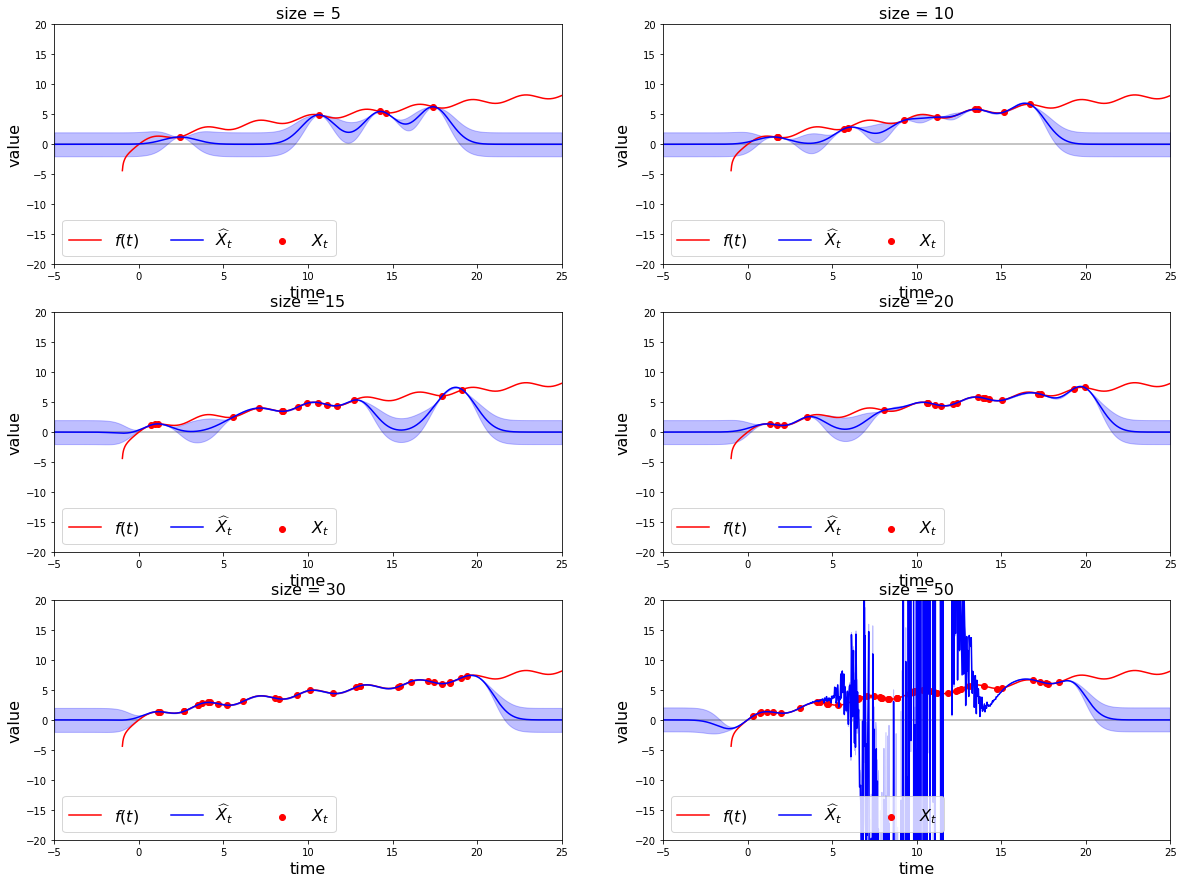

In [630]:
plt.figure(figsize=(20, 15))
    
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)

    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)

plt.show()

Теперь предположим, что измерения проводятся с погрешностью, то есть $\sigma > 0$. Скопируйте код выше в новую ячейку, раскомментируйте строчку кода и запустите.

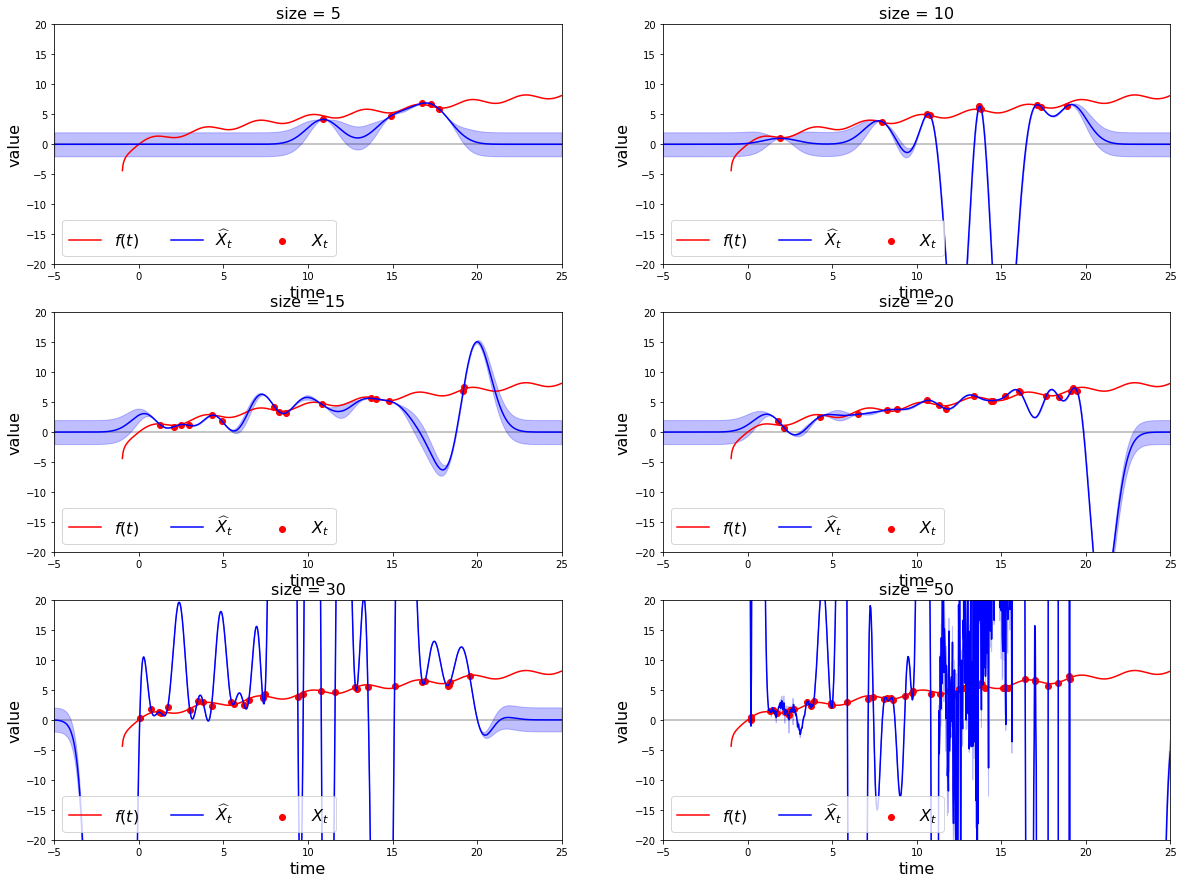

In [643]:
plt.figure(figsize=(20, 15))

def gpr(T, X, exp_cov):  # этот участок не меняется ниже
    # Применение регрессии
    gpr = GaussianProcessRegression(exp_cov).fit(T.reshape((-1, 1)), X)
    grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma
    return grid, predict, sigma

def plot(i, size, grid, predict, sigma):  # этот участок не меняется ниже
    # Построение графиков
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-5, 25))
    plt.ylim((-20, 20))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=3, ncol=3, fontsize=16)
    
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):

    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    
    X += norm(0, 0.3).rvs(X.shape)
    grid, predict, sigma = gpr(T, X, exp_cov)
    plot(i, size, grid, predict, sigma)
    

plt.show()

Почему получается так плохо? Что нужно сделать, чтобы это исправить (обратите внимание на ковариационную функцию)?

_________
**Ответ:** Заметим, что если процесс стационарен, то его дисперсия не меняется со временем и равна $R(0) = cov(X_0, X_0) = D[X_0]$. Таким образом, коэффициент корреляции (X_t и X_s, $t \leq s$) может быть записан как $r_{t,s} = \frac{cov(X_t, X_s)}{\sqrt{D[X_t]  D[X_s]}} = \frac{R(s - t)}{\sqrt{R(0) * R(0)}} = \frac{R(s - t)}{\left|R(0)\right|} $. В выше указанном случае $R(0) = 1$ и ковариационная функция совпадает с корреляционной. Таким образом, при приближении (по времени) двух точек их коэффициент корреляции стремится к единице. Однако, к исходным данным мы прибавили шум и корреляция этих случайных величин никак не может стремиться к единице, однако, алгоритм работает исходя из этого предположения и через близкие точки и его оценка выглядит странной при большом числе точек (в нашем случае, когда точки выборки взяты из U[0, 20] увеличение числа точек означает уменьшение расстояний между ними (ассимптотически и почти наверное, но на примерах выше - по факту)). Чтобы исправить это, скорректируем ковариационную функцию и сделаем её разрывной в нуле как на семинаре ($+ (1 - a) I(t == 0)$). Так мы не будем переоценивать корреляцию между величинами и решим эту проблему в некоторой степени (см. вопрос ниже). Сама ковариационная функция как была, так и останется гиперпараметром алгоритма и выбор значения a был и остаётся открытым вопросом.

Вообще говоря, для нашего процесса ($X_t = f(t) + \sigma\varepsilon_t$) не выполнено хотя бы условие о том, что функция среднего нулевая.
_________


Исправьте это.

__________
Досточно чуть-чуть скорректировать высоту и это решит проблему, при этом, на графике изменения будут почти не заметны. Как уже говорилось, выбор значения a - вопрос открытый, так же как и вопрос, почему мы выбрали именно такую функцию exp_cov c a=s=1


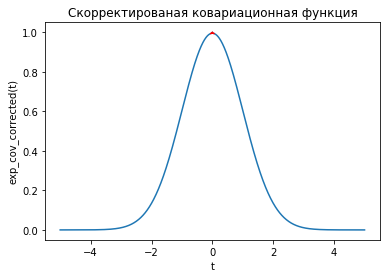

1.0

In [642]:
# <Исправление>
def exp_cov_corrected(t, a=0.995, s=1):
    vals = a * np.exp(-((t ** 2).sum(axis=-1))**(1) / (2 * s ** 2))
    add = ((1- a) * (t == np.zeros(t.shape[-1])).reshape(vals.shape)) 
    return vals + add


grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.plot(grid, exp_cov_corrected(grid.reshape((-1, 1))))
small_grid = grid[(grid > -0.05) & (grid < 0.05)]
plt.plot(small_grid, exp_cov_corrected(small_grid.reshape((-1, 1))), color="red")
plt.title("Скорректированая ковариационная функция")
plt.xlabel("t")
plt.ylabel("exp_cov_corrected(t)")
plt.show()
exp_cov_corrected(np.array([0]))

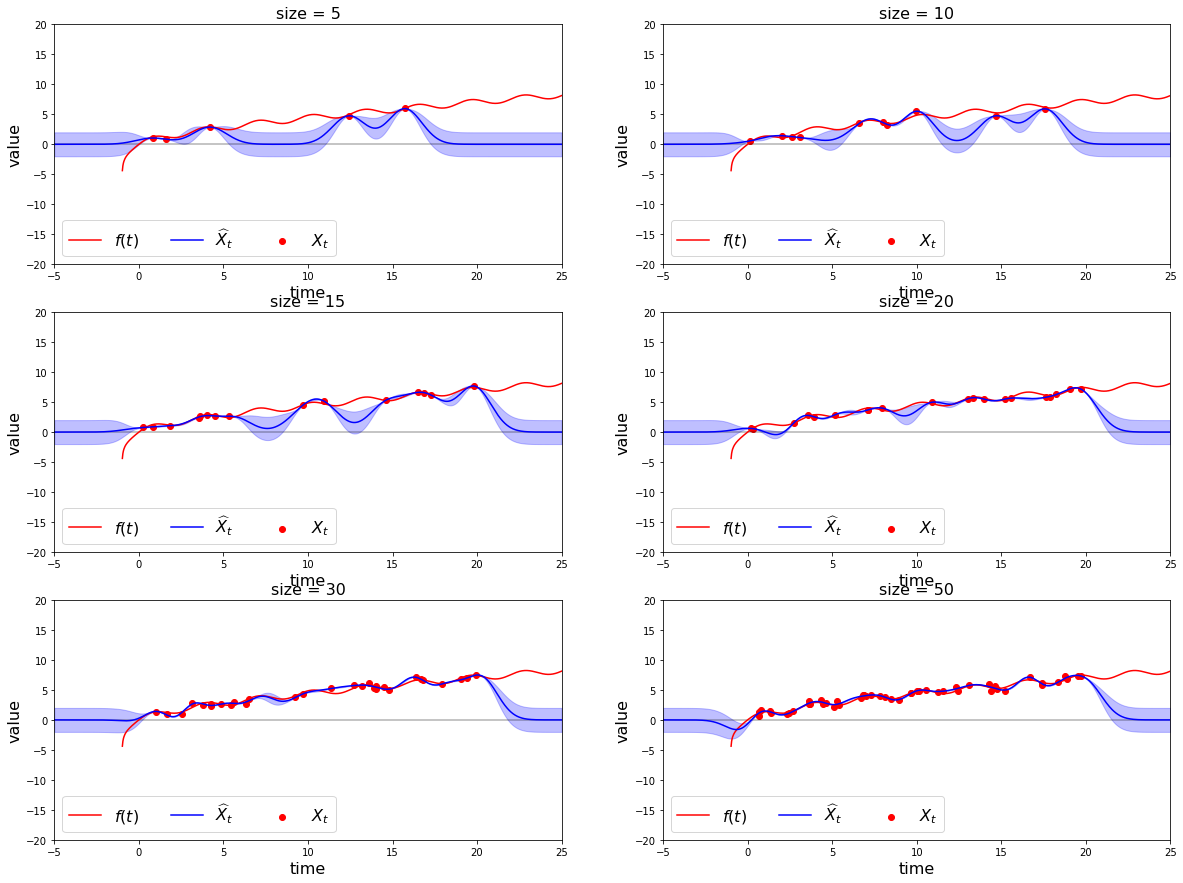

In [644]:
plt.figure(figsize=(20, 15))
  
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):
    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    X += norm(0, 0.3).rvs(X.shape)
    
    grid, predict, sigma = gpr(T, X, exp_cov_corrected)
    plot(i, size, grid, predict, sigma)
    
plt.show()

Почему стало лучше?

____________
**Ответ:** как уже писалось выше, мы дали алгоритму более уместную ковариационную функцию процесса $X_t + \xi_t$, учитывающую наличие шума.
____________

Однако, это все равно не поясняет, почему в самом первом случае (при $\sigma=0$) мог наблюдаться похожий эффект. В чем его причина?

____________
**Ответ:** алгоритм имеет ковариационную функцию одного процесса, а значения - какого-то другого, для которого не выполнено, например условие нулевой функции среднего. Однако, локально наш процесс может быть предсказан с данной ковариационной функцией с рядом оговорок.

(Например, на на отрезке без точек выборки в его окрестности будут предсказаны нулевые значения процесса, что, для нашего процесса, является хорошим приближением только в окрестности нуля времени, c чем дальше мы будем бороться)
____________

Пойдем теперь дальше. Вспомним наше предположение о том, что математическое ожидание равно нулю, хотя на самом деле это не так.
Давайте это исправим.
В примере выше перед применением регрессии вычтете среднее значение, а после --- добавьте обратно.

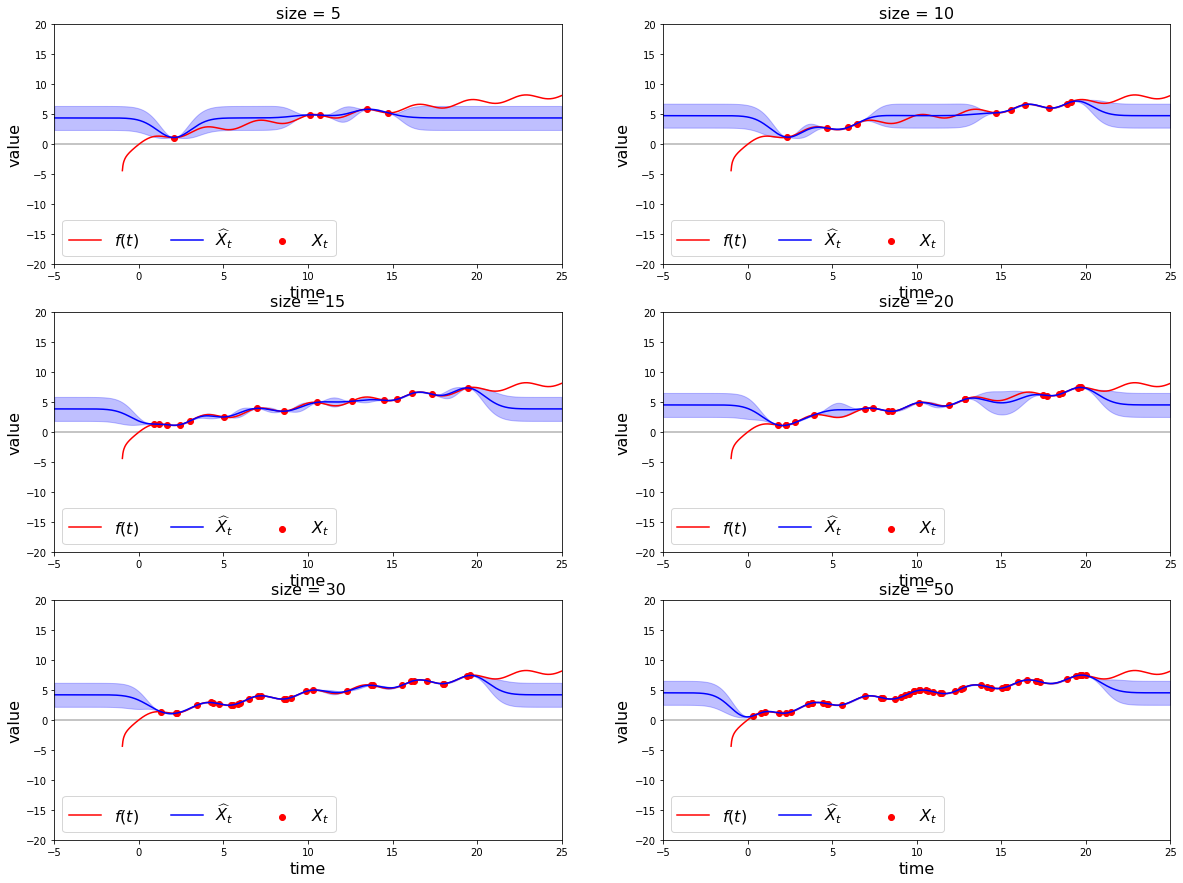

In [646]:
# <Код и графики>
plt.figure(figsize=(20, 15))
  
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):
    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)
    X_mean = X.mean()
    X -= X_mean
    grid, predict, sigma = gpr(T, X, exp_cov_corrected)
    predict  += X_mean
    X += X_mean
    plot(i, size, grid, predict, sigma)
    
    
plt.show()

Лучше, но все равно чего-то не хватает.
Может, приблизить линейной регрессией?

Проделайте аналогичные действия, построив сначала линейную регрессию, затем вычев ее значения из точек данных перед применением регрессии на гауссовских процессах, а после --- добавив обратно значения линейной регрессии для всех точек, в которых вы хотите построить предсказания.

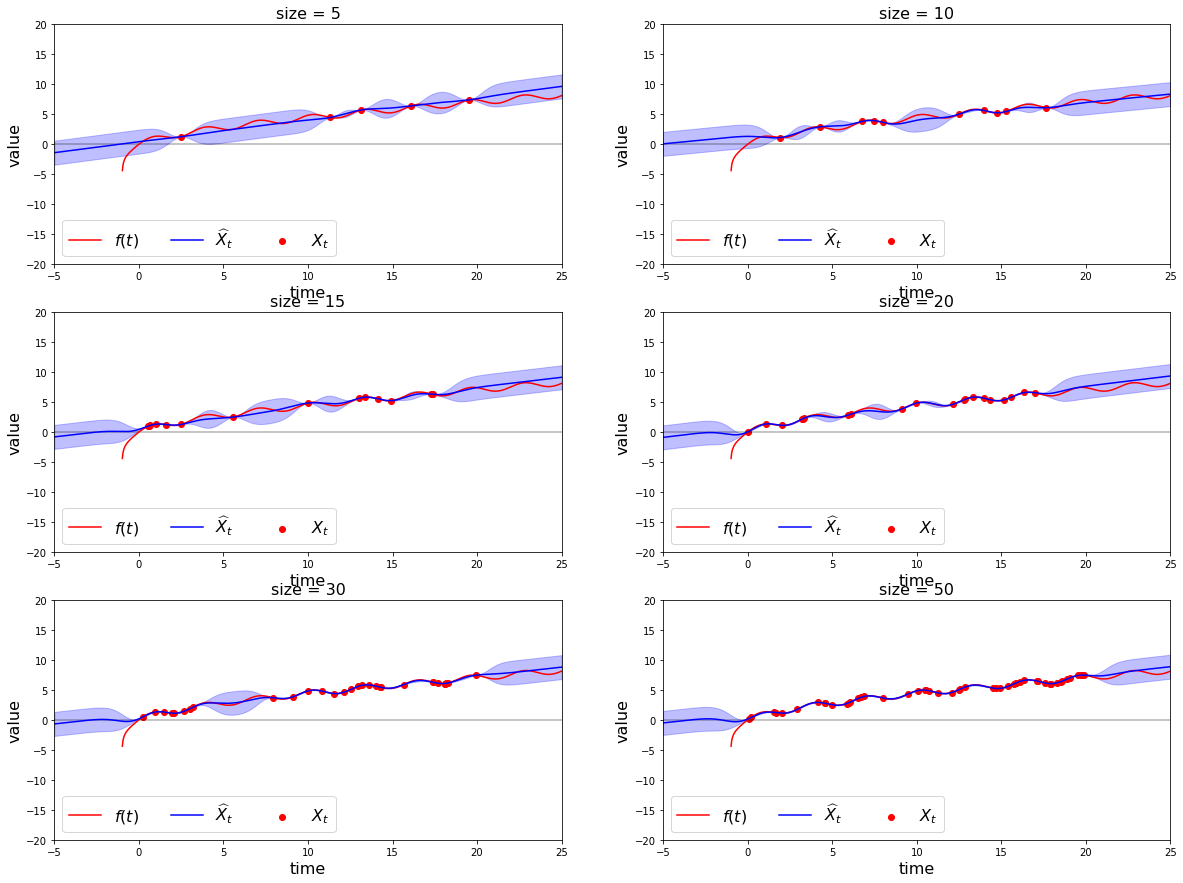

In [647]:
from sklearn.linear_model import LinearRegression
# <Код и графики>
plt.figure(figsize=(20, 15))
  
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):
    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)
    X = calc_f(T)
    
    # Сначала выполните код в этой ячейке с закомментированной строчкой кода.
    # Затем скопируйте код в новую ячейку, раскомментируйте строчку и выполните код.
    # X += norm(0, 0.3).rvs(X.shape)
    model = LinearRegression()
    model.fit(T.reshape((-1,1)), X)
    X -= model.predict(T.reshape((-1,1)))
    grid, predict, sigma = gpr(T, X, exp_cov_corrected)
    predict  += model.predict(grid.reshape((-1,1)))
    X += model.predict(T.reshape((-1,1)))
    plot(i, size, grid, predict, sigma)
    
    
plt.show()

_______________
**Комментарий:** теперь мы исправили проблему ненулевой функции среднего, хотя бы в какой-то степени. 
_______________
Разберемся подробнее в том, что происходит.

Допустим, мы хотим приблизить простую линейную функцию.
Построим график выборки и график предсказаний с помощью линейной регрессии.

Построим так же график ошибок, то есть точек $X_{t_i} - \widehat{f}(t_i)$, где $\widehat{f}$ --- линейная регрессия.

______
**Комментарий:** Ранее применение самостоятельно написанной линейной регрессии было раскритиковано, поэтому сейчас будет применен класс sklearn.linear_model.LinearRegression. Как следует из описания, это "this is just plain Ordinary Least Squares". Можно было бы применить Ridge или Lasso (с l1 или l2 регуляризацией), но, судя по графикам, здесь это не обосновано.

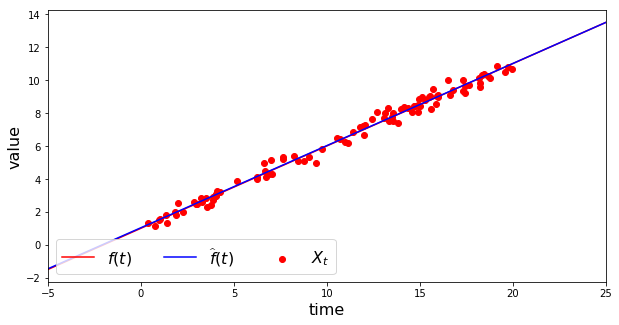

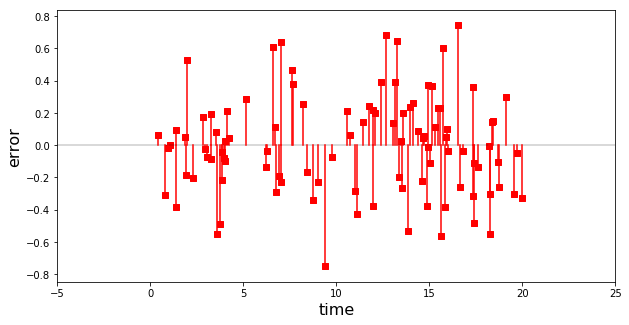

In [239]:
def f_lin(x):
    return x / 2 + 1

T = uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = f_lin(T)
X += norm(0, 0.3).rvs(X.shape)

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))

lr = LinearRegression() 
lr.fit(T, X)
predict = lr.predict(grid) # <оценка с помощью линейной регрессии>

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, f_lin(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))


for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - lr.predict([T[i]])], color='red')
    plt.scatter(T[i], X[i] - lr.predict([T[i]]), marker='s', color='red')


plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что можно сказать про остатки?

**Ответ:** Для них выполнены предположения линейной регрессии (несмещённое нормальное распределение с постоянной дисперсией). Можно было бы запустить статистические тесты, но эти продположения выполнены по построению процесса (мы сделали процесс из условия регрессии в явном виде).

Теперь посмотрим на функцию, с которой мы имели дело ранее.

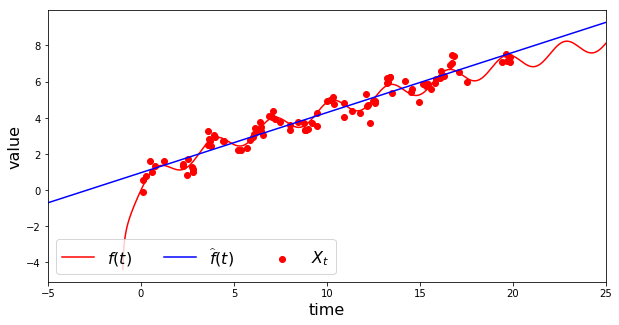

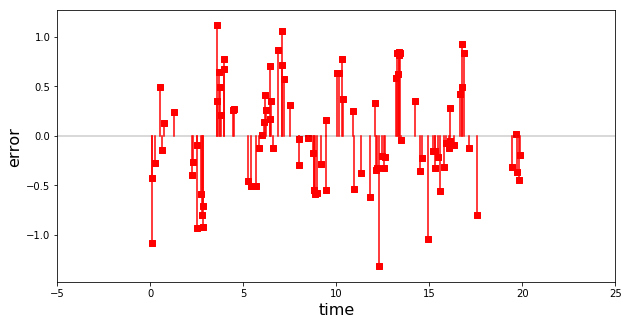

In [648]:
# <Постройте тут аналогичные графики>

T = uniform(loc=0, scale=20).rvs(size=100).reshape((-1, 1))
X = calc_f(T)
X += norm(0, 0.3).rvs(X.shape)

grid = np.linspace(-5, 25, 1000).reshape((-1, 1))

lr = LinearRegression()
lr.fit(T, X)
predict = lr.predict(grid) # <оценка с помощью линейной регрессии>

# График выборки и линейной регресии
plt.figure(figsize=(10, 5))
plt.plot(grid, calc_f(grid), color='red', label='$f(t)$')
plt.plot(grid, predict, color='blue', label='$\widehat{f}(t)$')
plt.scatter(T, X, color='red', label='$X_t$')
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.legend(loc=3, ncol=3, fontsize=16)
plt.show()

# График ошибок
plt.figure(figsize=(10, 5))


for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - lr.predict([T[i]])], color='red')
    plt.scatter(T[i], X[i] - lr.predict([T[i]]), marker='s', color='red')


plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('error', fontsize=16)
plt.show()

Что тут с остатками?

**Ответ:** остатки имеют явную периодичность, которая прямо зависит от периода процесса (просто нужно посмотреть на график выше и на этот одновременно, расположив их друг под другом, как в ноутбуки). Короче говоря, предположения линейной регрессии можно считать выполнеными, только если рассматривать большие (по t >> периода процесса без шума) промежутки (что мы и делаем, получая хороший результат). С другой стороны, теперь мы можем дополнительно прогнозировать зависимость в остатках (она есть).

Давайте приближать эту зависимость в остатках регрессией на основе гауссовских процессах.

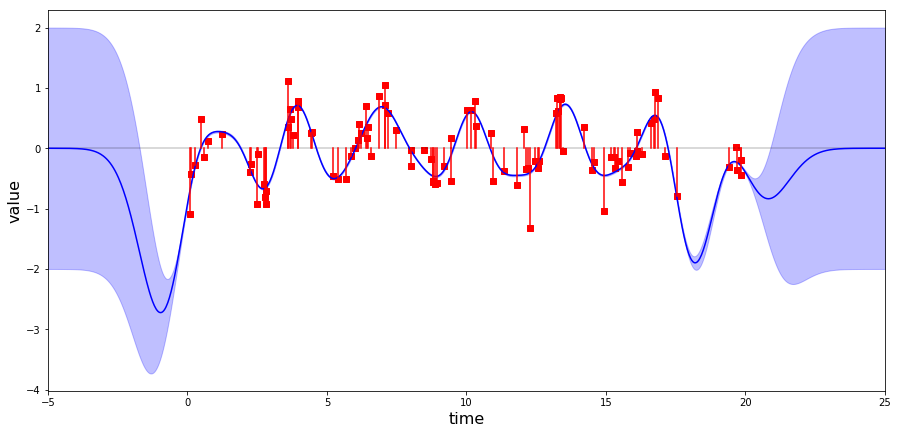

In [652]:
values_to_predict = X - lr.predict(T)
gpr = GaussianProcessRegression(exp_cov_corrected).fit(T, values_to_predict.reshape(values_to_predict.shape[0]))
grid = np.linspace(-5, 25, 1000).reshape((-1, 1))
predict, sigma = gpr.predict(grid)
grid, predict, sigma = np.array(grid).ravel(), predict, sigma

plt.figure(figsize=(15, 7))
plt.plot(grid, predict, color='blue')
plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                 color='blue', alpha=0.25)
for i in range(len(T)):
    plt.plot([T[i], T[i]], [0, X[i] - lr.predict([T[i]])], color='red')
    plt.scatter(T[i], X[i] - lr.predict([T[i]]), marker='s', color='red')
plt.hlines(0, -5, 25, alpha=0.2)
plt.xlim((-5, 25))
plt.xlabel('time', fontsize=16)
plt.ylabel('value', fontsize=16)
plt.show()

Сделайте подробные выводы.

**Ответ:** Коротко, не нужно применять метод, не проверяя его предположения.
Т.е. для предсказания случайных процессов, нужно сначала предсказать и отделить тренд, например, линейной регрессией, чтобы было выполнено хотя бы предположение о нулевой фунции среднего. Далее, если регрессия даёт приемлемый результат и в остатках есть какие-то зависимости, то логично выделить периодическую часть и прогнозировать её отдельно, что мы сделали с помощью регрессии на гауссовских процессах, которая, однако, не учитывает явную периодичность процесса.  
Более того видим, что подмена ковариационной функции позволяет бороться с выбросами и шумом - третьей составляющей процесса.

С другой стороны, наше предсказание явно недооценивает доверительные интервалы для значений. Ниже мы покажем, что это вызвано несоответствующей ковариационной функцией.


__________________________________________
__________________________________________
Рассмотрим теперь гауссовский процесс $(X_t, t\in\mathbb{R}_+)$, заданный как $X_t = t + W_{t+1} - W_{t}$, где $(W_t, t\in\mathbb{R}_+)$ --- винеровский процесс.
Сгенерируйте данные в соответствии с этой моделью. Для генерации винеровского процесса используйте код из предыдущего задания. По этим данным постройте комбинацию линейная регрессия + регрессия на гауссовских процессах, как в примерах выше. Как и раньше, проведите эксперимент для различного объема данных.

**Комментарий:** $W_{t+1} - W{t} \sim N(0, 1)$, по-этому линейная регрессия отработает хорошо (если не выбирать значения $X_t$, расположенные ближе, чем на 1, то будут выполнены все предположения линейной регрессии, но даже если выбирать, то будет невыполнена только независимость ошибок для некоторых пар значений, что, как мы увидим ниже, не скажется сильно на результате). Таким образом, после применения линейной регрессии, получим почти процесс $Y_t =  W_{t+1} - W{t}$  (в случае успешной регрессии разница между полученным и данным процессами будет пренебрежимо малой), для которого, из номера 2 шестого теоретического домашнего известна ковариационная функция, и далее мы покажем, почему важно выбирать хорошую ковариационную функцию

** Старый, но полезный код **

In [654]:
import scipy.stats as sps  # неужели мы ещё этого не сделали?

class RVSCache:
    """Класс, который кэширует выделение 'случайных величин'
    (выделять много раз по одной очень медленно (в десятки раз))
    - он заранее выделяет много (size) значений и отдаёт их по одному"""
    def __init__(self, size=1000, dist=sps.norm):
        """size - размер кэша
        dist - распределение
        """
        assert size > 0
        self._i = 0  # текущее положении в кэше
        self._s = size 
        self._v = dist.rvs(size=size)
        self._d = dist
        self._got = 0  # сколько уже получили (всего)
    def get(self):
        """Получить одну реализацию случайной величины"""
        self._got += 1
        val = self._v[self._i]
        self._i += 1
        if (self._i == self._s):
            self._v = self._d.rvs(size=self._s)
            self._i = 0
        return val
    
class NormTree:
    """Двоичное дерево, которое хранит значения xi_i
    и генерирует их не заранее, но на ходу (не меняя уже сгенерированных)"""
    def __init__(self, father=None, left=True, rvs_cache=None):
        self._lson = None
        self._rson = None
        self._father = father
        
        if (rvs_cache is None):
            if (father is None):
                self._rvs_cache = RVSCache()
            else:
                self._rvs_cache = father._rvs_cache
        else:
            self._rvs_cache = rvs_cache
            
        self._value = self._rvs_cache.get()
        
    def __str__(self):
        return ("[Value = {}, lson = {}, rson = {}]"
              .format(self._value,  self._lson, self._rson))
    def lson(self):
        if self._lson is None:
            self._lson = NormTree(self, True)
        return self._lson
    def rson(self):
        if self._rson is None:
            self._rson = NormTree(self, False)
        return self._rson
    
class ShauderTree:
    """Двоичное дерево, (дерево отрезков, на которых функции 
    шаудера не обращаются в ноль), которое хранит данные для
    быстрого реккурентного вычисления суммы
    sum_{k=1}^{precision - 1} S_k(t) * xi_k
    за O(log(precision))"""
    def __init__(self, father=None, left=True):
        self._lson = None
        self._rson = None
        self._father = father
            
        if (father is None):
            self._k = 1  # номер функции шаудера
            self._n = 0 
            # Расстояние до корня в дереве по рёбрам. (от корня до корня = 0)
            # Для k-ой функции Шаудера оно равно n, где n взято из книги.
            
            self._height =  2. ** (-(self._n/2.) -1)  # =  0.5
            # высота треугольника (см. рис 3.3) k - ой функции Шаудера,
            # где  2**(self._n) <= l < 2**(self._n + 1)
            self._l = 0.  # левая
            self._r = 1.  # и правая координата основания треугольника 
        else:
            self._n = self._father._n + 1
            self._height = 2. ** (-(self._n/2.) -1)
            if (left):
                self._k = father._k * 2
                self._l, self._r = self._father._l, self._father._c
            else:
                self._k = father._k * 2 + 1
                self._l, self._r = self._father._c, self._father._r
        self._c = (self._l + self._r) / 2.  # середина основания трегольника
    def __str__(self):
        return ("[l = {}, r = {}, n = {}, k = {}, lson = {}, rson = {}]"
              .format(self._l, self._r, self._n, self._k, self._lson, self._rson))
    def lson(self):
        if self._lson is None:
            self._lson = ShauderTree(self, True)
        return self._lson
    def rson(self):
        if self._rson is None:
            self._rson = ShauderTree(self, False)
        return self._rson
    def lson_k(self):
        return self._k * 2  # номер функции, которая делит отрезок текущей надвое
    def rson_k(self):
        return self._k * 2 + 1  # вторая такая же
    def shauder_sum_eval(precision, norm_tree, shauder_tree, t):
        """Считает рекурсивно сумму \sum Sk(t) * xi_k, рассматривая только те Sk,
        которые не равны нулю в любой окрестности точки. O(log(precision))"""
        #print(str(tree), t)
        assert (shauder_tree._l <= t <= shauder_tree._r)
        res = 0.
        if (t <= shauder_tree._c):  # positive_slope
            value_at_this_vertex = (
                shauder_tree._height * (t - shauder_tree._l)
                / (shauder_tree._c - shauder_tree._l) * norm_tree._value
            ) # подобие треугольников
            
            if (shauder_tree.lson_k() < precision):  
                # слагаемые индексируются с нуля
                return (
                    value_at_this_vertex
                    + ShauderTree.shauder_sum_eval(
                        precision,
                        norm_tree.lson(), 
                        shauder_tree.lson(),
                        t)
                )
            else:
                return value_at_this_vertex

        else:
            value_at_this_vertex = (
                shauder_tree._height * (shauder_tree._r - t)
                / (shauder_tree._r - shauder_tree._c) * norm_tree._value
            ) # симметрично
            
            if (shauder_tree.rson_k() < precision):  
                # слагаемые индексируются с нуля
                return (
                    value_at_this_vertex
                    + ShauderTree.shauder_sum_eval(
                        precision,
                        norm_tree.rson(),
                        shauder_tree.rson(),
                        t)
                )
            else:
                return value_at_this_vertex
            
class PowerWinerProcess:
    def __init__(self, precision=10000, rvs_cache_size=1000):
        self._rvs_cache = RVSCache(size=rvs_cache_size)
        self._precision = precision
        self._xi0 = [sps.norm.rvs()]
        self._xi = [NormTree(rvs_cache=self._rvs_cache)]
        # здесь лежат _xi_i для i > 0 в виде полного двоичного дерева,
        # соответствующего отрезкам, на которых функции Шаудера 
        # не нулевые, при это вершины дерева в памяти генерируются
        # по мере необходимости
        self._shauder = ShauderTree()
        self._starts = [0, self._xi0[0]]  # значения W_t для целых t
        self._log = False
    def __getitem__(self, times):
        times = np.array(times)
        if times.max() >= len(self._xi):
            # выделяем новые xi_i^j - для отрезков [n, n+1], которые
            # ранее не были рассмотрены
            addition = int(times.max() + 1.) - len(self._xi)  # число новых отрезков
            add_xi0 = sps.norm.rvs(size=(addition))
            add_xi = [None] * addition
            self._starts += list(self._starts[-1] + np.cumsum(add_xi0))
            self._xi0 += list(add_xi0)
            self._xi += list(add_xi)
        return list(map(self._get_at, times))
    def _get_at(self, t):
        """Возвращает значение процесса в точке (предполагается,
        что внутренние значения _xi и _xi0 уже сгенерированы)"""
        t_integer_part = int(t)
        t_fractional_part = t - t_integer_part
        if (self._xi[t_integer_part] is None):
            self._xi[t_integer_part] = NormTree(rvs_cache=self._rvs_cache)
        return (self._starts[t_integer_part]
                + self._xi0[t_integer_part] * t_fractional_part + 
                + ShauderTree.shauder_sum_eval(
                    self._precision,
                    self._xi[t_integer_part],
                    self._shauder,
                    t_fractional_part)
               )

Построим график, чтобы увидеть, что мы ничего не сломали.

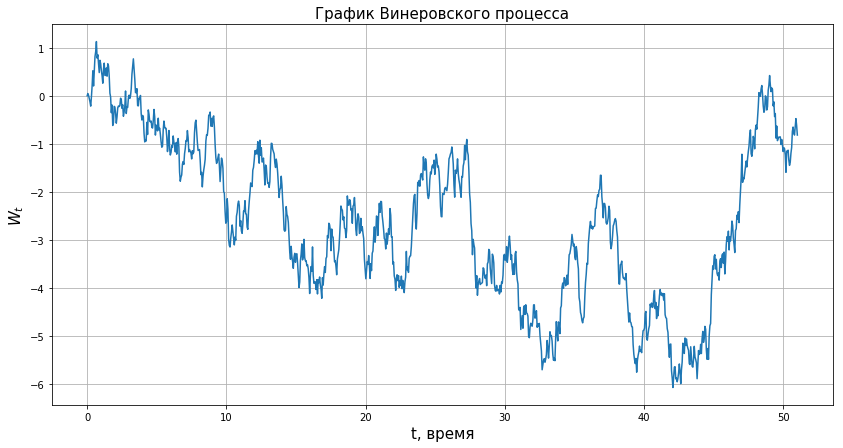

In [655]:
pwp = PowerWinerProcess()
grid = np.linspace(0, 17 * 3, 1000)
plt.figure(figsize=(14,7))
plt.plot(grid, pwp[grid])
plt.grid()
plt.title("График Винеровского процесса", fontsize=15)
plt.xlabel("t, время", fontsize=15)
plt.ylabel("$W_t$", fontsize=15)
plt.show()

Сделаем класс-обёртку ($X_t = t + W_{t+1} - W_{t}$), чтобы не думать.

In [656]:
class SomeXProcess:
    def __init__(self):
        self._pwp = PowerWinerProcess()
    def __getitem__(self, times):
        times = np.array(times)
        return times + self._pwp[times + 1.] - self._pwp[times]

Посмотрим на новый процесс $X_t$

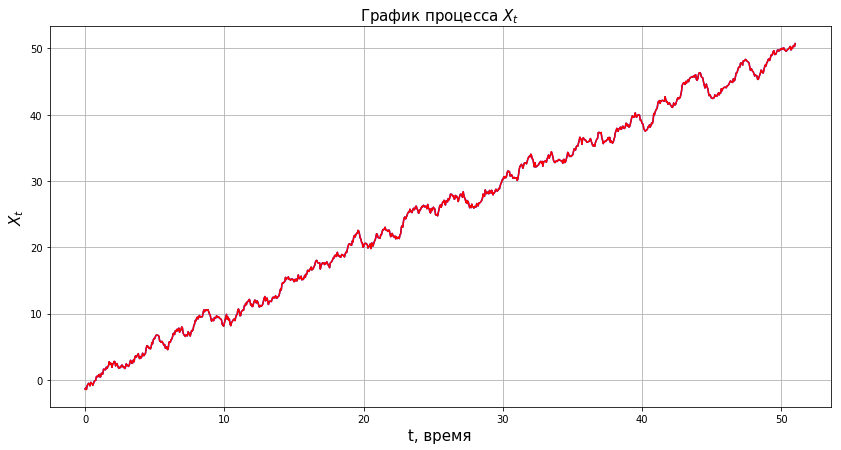

In [657]:
x_process = SomeXProcess()
grid = np.linspace(0, 17 * 3, 1000)
plt.figure(figsize=(14,7))
plt.plot(grid, x_process[grid], color="blue")
# проверка, что мы не пересоздаём траекторию (должны увидеть только один график) 
plt.plot(grid, x_process[grid], color="red")
plt.grid()
plt.title("График процесса $X_t$", fontsize=15)
plt.xlabel("t, время", fontsize=15)
plt.ylabel("$X_t$", fontsize=15)
plt.show()

На семинаре было доказано, что процесс $Y_t = W_{t+1} - W_{t} \sim N(0, 1)$ является стационарным в двух смыслах. Замечая, что $X_t = t + Y_t$, то во-первых, интуитивное понимание того, что мы хотели получить, совпадает графиком выше, во-вторых, мы знаем его ковариационную функцию.

Сделаем то, что нас просят, т.е. комбинацию линейной регрессии и регрессии на гауссовских процессах. Казалось бы, процесс создан для того, чтобы его прогнозировали именно так. 

Можно добавить шум к данным, чтобы прогноз был более реалистичным (мы редко прогнозируем совсем не зашумлённые данные). Добавим шум с малой дисперсией, чтобы был.

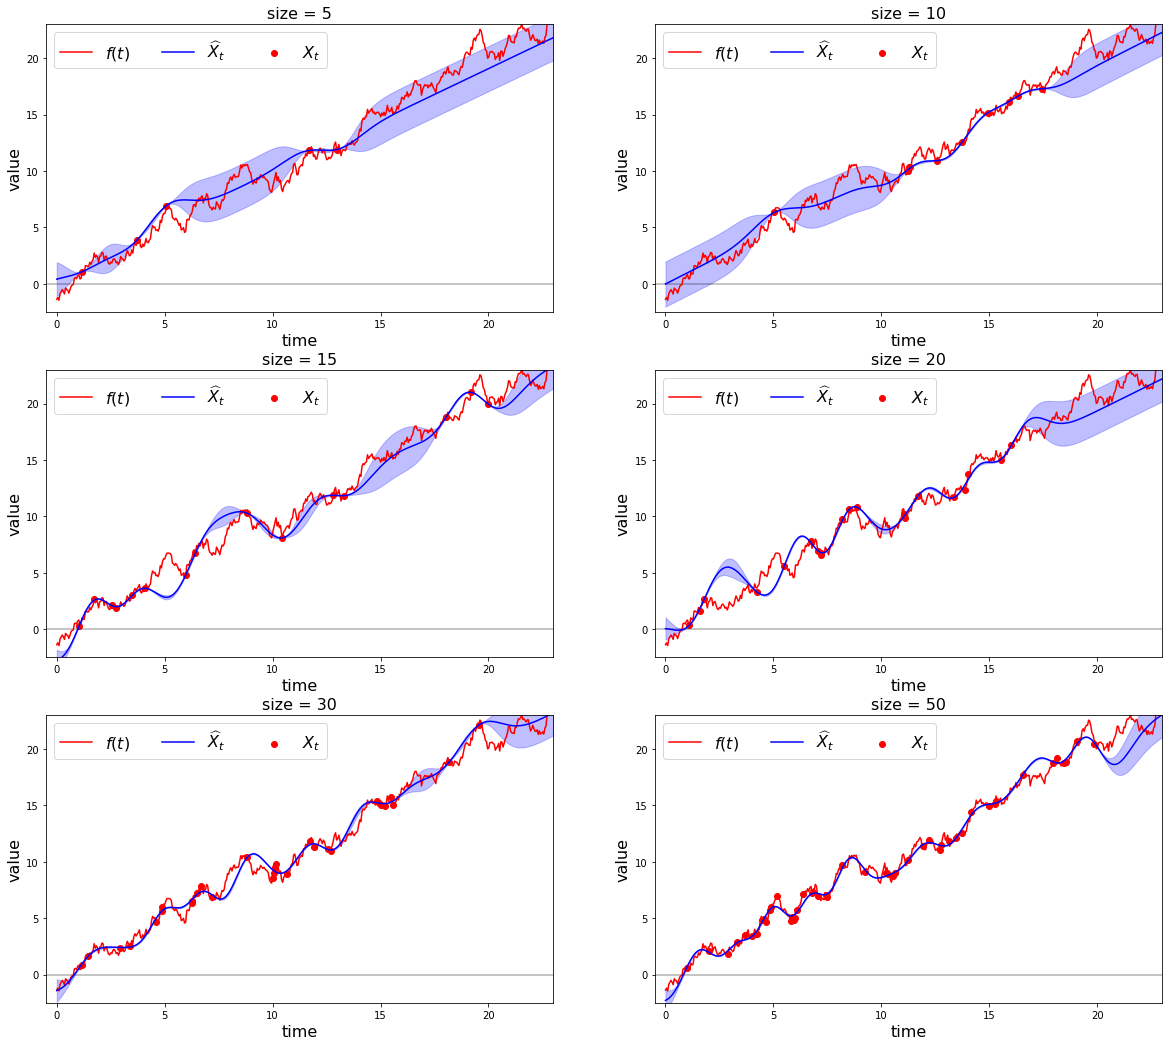

In [660]:
def x_process_cov(t):
    return exp_cov_corrected(t)
# <Код и графики>
plt.figure(figsize=(20, 18))
  
    
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):
    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)  
    X = x_process[T]
    
    X += norm(0, 0.1).rvs(X.shape)
    model = LinearRegression()
    model.fit(T.reshape((-1,1)), X)
    X -= model.predict(T.reshape((-1,1)))
    
    gpr = GaussianProcessRegression(x_process_cov).fit(T.reshape((-1, 1)), X)
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    predict  += model.predict(grid.reshape((-1,1)))
    X += model.predict(T.reshape((-1,1)))
    
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, x_process[grid.ravel()], color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-0.5, 23))
    plt.ylim((-2.5, 23))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=2, ncol=3, fontsize=16)
    
plt.show()

Казалось бы, регрессии хорошо предсказывает поведение процесса, когда имеется достаточно точек в окрестности прогнозируемого значения. Подсунем теперь ковариационную функцию именно этого процесса после применения линейной регрессии (считаем её достаточно успешной, почему она будет такой, обосновано выше) ($X_t - t = W_{t+1} - W_{t}$)  ($R(t) = max(0, 1 - |t|)$), где под модулем будем понимать норму ветора).

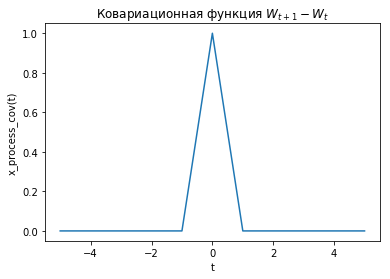

In [664]:
def x_process_cov(t):
    modules = ((t ** 2).sum(axis=-1)) ** 0.5
    zeros = np.zeros_like(modules)
    ones = np.ones_like(modules)
    R = np.max(np.array([zeros, ones - modules]), axis=0)
    return R

grid = np.linspace(-5, 5, 1001)
plt.figure(figsize=(6, 4))
plt.title("Ковариационная функция $W_{t+1} - W_{t}$")
plt.plot(grid, x_process_cov(grid.reshape((-1, 1))))
plt.xlabel("t")
plt.ylabel("x_process_cov(t)")
plt.show()

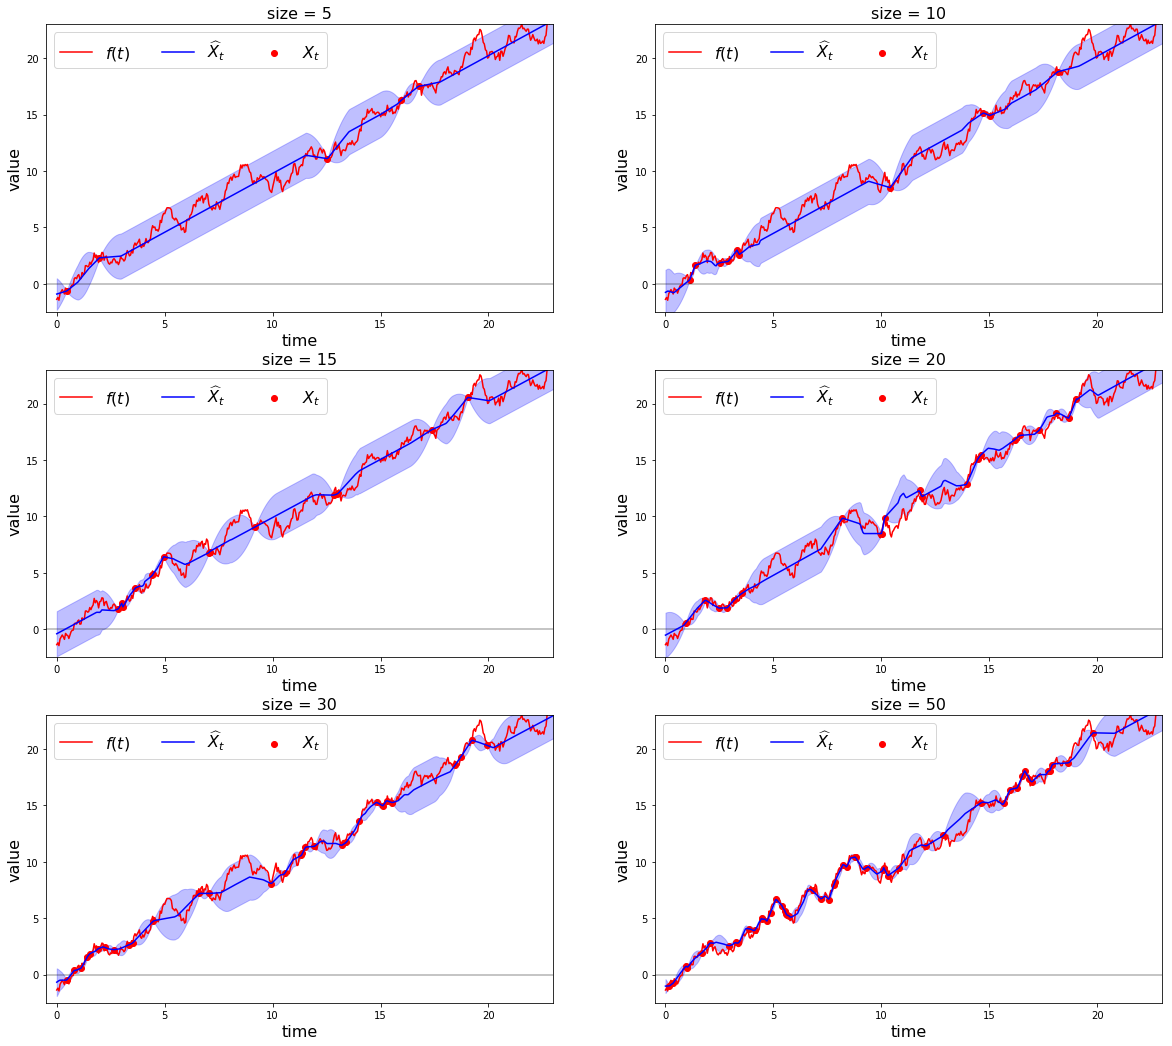

In [665]:
plt.figure(figsize=(20, 18))

grid = np.linspace(0, 17 * 3, 1000)  
    
# size --- количество наблюдаемых данных
for i, size in enumerate([5, 10, 15, 20, 30, 50]):
    # Генерация данных
    T = uniform(loc=0, scale=20).rvs(size=size)  
    X = x_process[T]
    
    X += norm(0, 0.1).rvs(X.shape)
    model = LinearRegression()
    model.fit(T.reshape((-1,1)), X)
    X -= model.predict(T.reshape((-1,1)))
    
    gpr = GaussianProcessRegression(x_process_cov).fit(T.reshape((-1, 1)), X)
    predict, sigma = gpr.predict(grid)
    grid, predict, sigma = np.array(grid).ravel(), predict, sigma

    predict  += model.predict(grid.reshape((-1,1)))
    X += model.predict(T.reshape((-1,1)))
    
    plt.subplot(3, 2, i + 1)
    plt.plot(grid, x_process[grid.ravel()], color='red', label='$f(t)$')
    plt.plot(grid, predict, color='blue', label='$\widehat{X}_t$')
    plt.fill_between(grid, predict + 2 * sigma, predict - 2 * sigma, 
                     color='blue', alpha=0.25)
    plt.scatter(T, X, color='red', label='$X_t$')
    plt.hlines(0, -5, 25, alpha=0.3)
    plt.xlim((-0.5, 23))
    plt.ylim((-2.5, 23))
    plt.title('size = {}'.format(size), fontsize=16)
    plt.xlabel('time', fontsize=16)
    plt.ylabel('value', fontsize=16)
    plt.legend(loc=2, ncol=3, fontsize=16)
    
plt.show()

**Комментарий:** Видим, что, хотя прогноз стал менее гладким и местами менее точным(субъективно) (ковариация нулевая для $|t|>1$), мы стали гораздо обьективнее оценивать дисперсию процесса и теперь доверительные интервалы имеют хоть какой-то смысл. (на графике с исходной ковариационной функцией доверительные интервалы не вмещают процесс в себя почти нигде, а на графике выше - почти везде вмещают.)

_________________________________________________
_________________________________________________
Скачайте датасет <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a>.
Задача состоит в том, чтобы для парусных яхт предсказать остаточное сопротивление на единицу массы смещения от размеров яхты и ее скорости. Рассмотрим зависимость величины `Residuary resistance` от `Froude number`. Постройте приближение этой зависимости с помощью комбинации линейной регрессии и регрессии на гауссовских процессах. Посчитайте ошибку предсказания и сравните ее с ошибкой предсказания с помощью простой линейной регрессии. Для линейной регрессии можно взять так же вторую и третью степень величины `Residuary resistance`.

__________________________________
Скачаем данные и оформим две величины в массивы X и y соответственно.

In [770]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data

--2017-11-12 18:38:04--  http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 11487 (11K) [text/plain]
Сохранение в каталог: ««yacht_hydrodynamics.data.2»».

yacht_hydrodynamics 100%[===================>]  11,22K  --.-KB/s    in 0,02s   

2017-11-12 18:38:05 (741 KB/s) - «yacht_hydrodynamics.data.2» сохранён [11487/11487]



Описание столбцов с данными:
1. Longitudinal position of the center of buoyancy, adimensional.
2. Prismatic coefficient, adimensional.
3. Length-displacement ratio, adimensional.
4. Beam-draught ratio, adimensional.
5. Length-beam ratio, adimensional.
6. Froude number, adimensional.

The measured variable is the residuary resistance per unit weight of displacement:

7.Residuary resistance per unit weight of displacement, adimensional. 

In [771]:
df = pd.read_table("yacht_hydrodynamics.data", sep="\s+", header=None, names=list(range(1, 8)))
df.head()

,1,2,3,4,5,6,7
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [772]:
X = df[6].values  # да, мы сделали нумерацию с единицы, как в описании данных
y = df[7].values
X[:5], y[:5]

(array([ 0.125,  0.15 ,  0.175,  0.2  ,  0.225]),
 array([ 0.11,  0.27,  0.47,  0.78,  1.18]))

________
Надо сначала в данные посмотреть бы

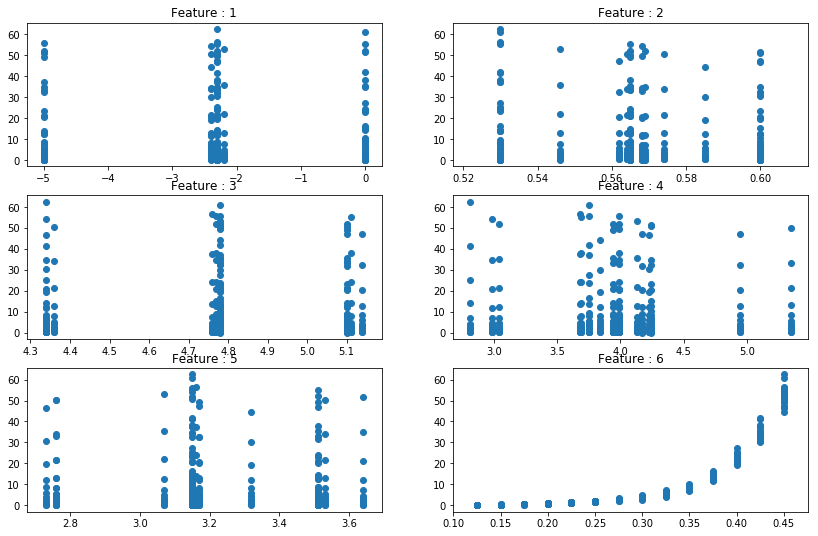

In [773]:
plt.figure(figsize=(14, 9))
for i in range(1, 7):
    plt.subplot(3, 2, i)
    plt.title("Feature : %d" % i)
    plt.scatter(df[i].values, y)
plt.show()

Построим попарные графики

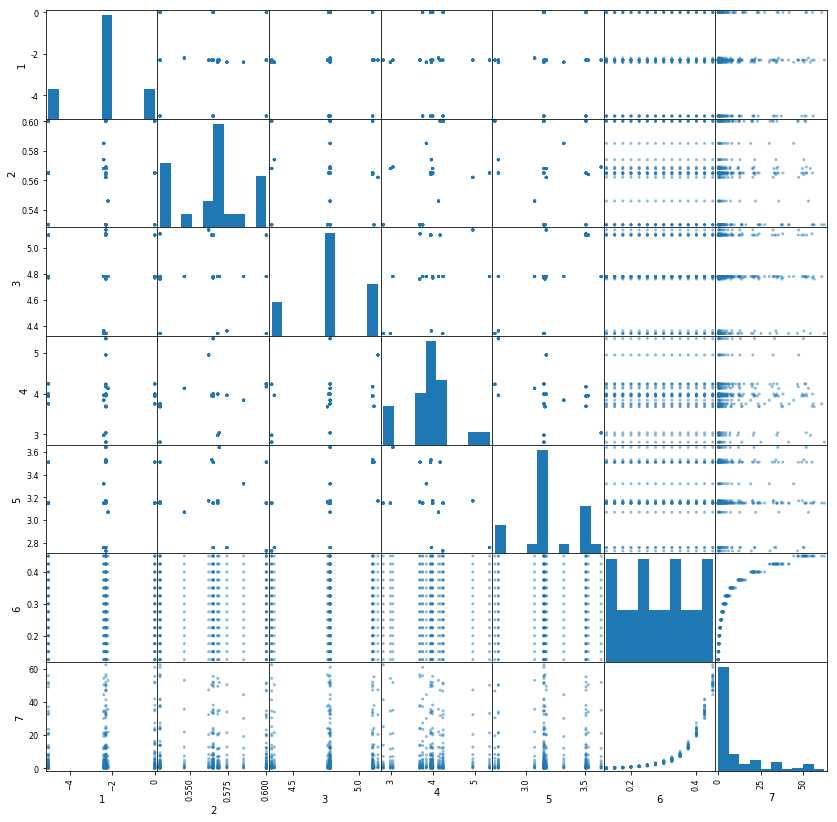

In [774]:
pd.scatter_matrix(df, figsize=(14,14))
plt.show()

Построим графики попарной корелляции

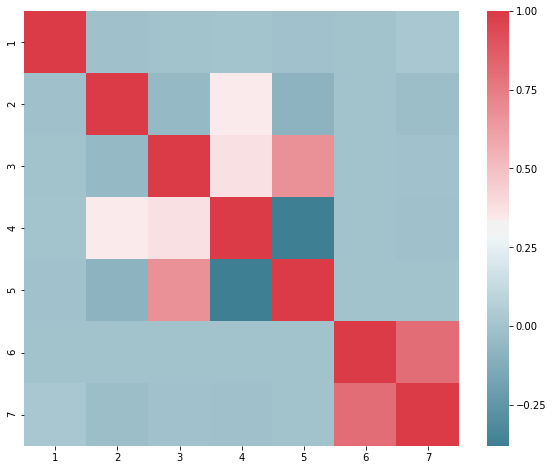

In [775]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Собственно, визуально и по корреляции от остальных признаков данные зависят никак.

______
Сделаем наш прогноз, собственно. Из условия непонятно, что считать ошибкой и как эту ошибку считать. Будем считать ошибкой MSE, а ошибку будем считать двумя способами - глобально по всей обучающей выборке (наверное, так предполагалось в условии) и с помощью кросс-валидации (среднее по трём фолдам) в случае последней будет всё-таки neg_MSE и перед результатом появится минус.

**Прогноз только по регрессии, с квадратами и кубами.**

In [776]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
X_lr = np.array([X, X**2, X**3]).T
model = LinearRegression()
cross_val_score(model, X_lr, y, scoring="mean_squared_error", cv=3).mean()

-4.1526986980889218

In [777]:
model.fit(X_lr, y)
mean_squared_error(y, model.predict(X_lr))

3.7645361959616439

**Прогноз по линейной регрессии (только с одним признаком) и регрессии на гауссовких процессах**

Прокомментируем код ниже. Так как мы имеем повторяющиеся признаки в выборке, но хотим обращать матрицу С в гауссовской регресии, для повторяющихся признаков будем прогнозировать среднее целевое значение (среднее - потому что функционал потерь - MSE (минимизирует ошибку в точке)).

Более того, перед прогнозированием, отнормируем данные по времени перед применением регресси на гауссовских процессах (разделим на выборочную дисперсию - вроде бы это хороший тон, (да и гауссовская регрессия будет делать более гладкий и предсказуемый прогноз) возможно, нужно было отнормировать и y. Нормирование данных можно было бы заменить на подгон параметров ковариационной функции (и самой функции) по сетке или как-нибудь по другому, но, как показано ниже, всё и так хорошо работает, с учётом, что на 308 позиций в исходных данных только 14 различных значений признака).

In [778]:
def exp_cov(t, a=1, s=1):
    return a * np.exp(-(t ** 2).sum(axis=-1) / (2 * s ** 2))

# сделаем класс для красоты
class LinearAndGaussianProcessRegression:
    def __init__(self, cov_function, uniq=False):
        self.gpr = GaussianProcessRegression(cov_function)
        self.lr = LinearRegression()
        self.uniq = uniq
    def fit(self, X, y, **kwargs):
        X = np.copy(np.array(X))  # не портим данные
        y = np.copy(np.array(y))
        # aka X <-> T, y <-> Xt
        self.lr.fit(X, y)
        if self.uniq: 
            X_map = dict()
            for i in range(X.shape[0]):
                key = tuple(X[i])
                if key in X_map:
                    X_map[key].append(y[i])
                else:
                    X_map[key] = [y[i]]
            X = []
            y = []
            for key in X_map:
                X.append(key)
                y.append(np.array(X_map[key]).mean())
            X = np.array(X).reshape((-1, 1))
            y = np.array(y)
        self.X_mean = X
        self.y_mean = y
        y_shifted = y - self.lr.predict(X).ravel()
        self.gpr.fit(X, y_shifted)
        return self
    def full_predict(self, X):
        X = np.array(X)
        y_shift = np.array(self.lr.predict(X))
        # print(X_shifted)
        values, sigmas = self.gpr.predict(X)
        # print(values.shape)
        # print(y_shift.shape)
        values += y_shift.ravel()
        return values , sigmas
    def predict(self, X):
        return self.full_predict(X)[0]  # соответствует формату sklearn
    def get_params(self, deep = False):
        return {"cov_function":self.gpr.cov_function, "uniq":self.uniq}

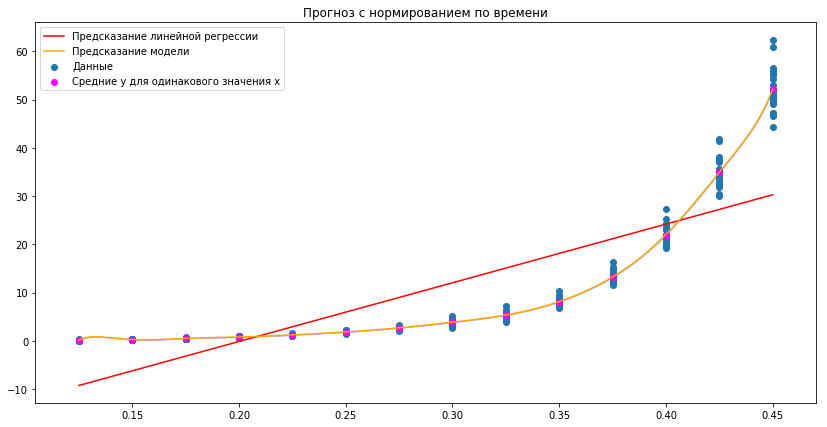

2.4652904433479108

In [785]:
model = LinearAndGaussianProcessRegression(exp_cov, uniq=True)
model.fit(X.reshape((-1, 1)) / X.std(), y)


grid = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(14, 7))
plt.scatter(X, y, label="Данные")
plt.plot(grid, model.lr.predict(grid.reshape((-1, 1)) / X.std()),
         color="red", label="Предсказание линейной регрессии")

plt.title("Прогноз с нормированием по времени")
plt.scatter(model.X_mean.ravel() * X.std(), model.y_mean.ravel(),
            color="magenta", label="Средние y для одинакового значения x")
#plt.scatter(X, model.predict(X.reshape((-1, 1))), color="red")
values, sigmas = model.full_predict(grid.reshape((-1, 1)) / X.std()) 
plt.plot(grid , values,
         color="orange", label="Предсказание модели")
plt.fill_between(grid, values + 2 * sigmas, values - 2 * sigmas, 
                 color='blue', alpha=0.25)
# print(sigmas)
plt.legend()
plt.show()


mean_squared_error(y, model.predict(X.reshape((-1, 1)) / X.std()))

In [786]:
print(X.shape)
cross_val_score(model, X.reshape((-1, 1)) / X.std(), y, scoring="mean_squared_error", cv=3).mean()

(308,)


-2.8666662823361428

Для примера, покажем **процесс без нормирования** по времени, чтобы было понятно, что здесь оно полезно.

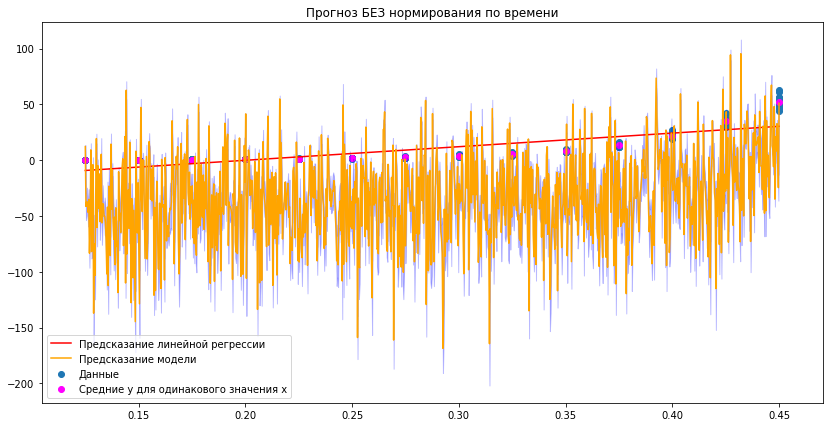

1910.4528607610093

In [787]:
model = LinearAndGaussianProcessRegression(exp_cov, uniq=True)
model.fit(X.reshape((-1, 1)), y)


grid = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(14, 7))
plt.scatter(X, y, label="Данные")
plt.plot(grid, model.lr.predict(grid.reshape((-1, 1))),
         color="red", label="Предсказание линейной регрессии")

plt.title("Прогноз БЕЗ нормирования по времени")
plt.scatter(model.X_mean.ravel(), model.y_mean.ravel(),
            color="magenta", label="Средние y для одинакового значения x")
#plt.scatter(X, model.predict(X.reshape((-1, 1))), color="red")
values, sigmas = model.full_predict(grid.reshape((-1, 1))) 
plt.plot(grid , values,
         color="orange", label="Предсказание модели")
plt.fill_between(grid, values + 2 * sigmas, values - 2 * sigmas, 
                 color='blue', alpha=0.25)
# print(sigmas)
plt.legend()
plt.show()


mean_squared_error(y, model.predict(X.reshape((-1, 1))))

Так себе прогноз. Вроде бы, прогноз **БЕЗ** нормирования исходных данных можно охарактеризовать как переобучение.

**Вывод:** Видим, что гауссовская модель, несмотря на нарушение ряда предположений, процесс явно проходит через средние точки данных для фиксированных значений времени и, видимо, качественного улучшения результата не будет просто из-за того, что в выборке из 308 значений только 14 различных значений признаков. Более того, визуально, переобучения не происходит, хотя очевидно, что много предположений было нарушено (остатки после линейной регрессии даже не нормальные).
Более того, очень полезным было нормирование по времени, оно сделало прогноз достаточно гладким.
Качество на кросс-валидации значимо лучше, чем у линейной регрессии с тремя признаками.

Таким образом, далее рассматривать конкректно этот датасет не интересно.

In [788]:
# Посмотрим, как работает константное решение (так себе)
mean_squared_error(y, np.ones_like(y) * (y.mean() ))

229.09422487244899

________________________________________
________________________________________
Дополнительно вы можете попробовать <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process">реализацию</a> регрессии на гауссовских процессах в `sklearn`.

Реализация интересна тем, что самостоятельно подгоняет параметры ядра - ковариационной функции (The kernel specifying the covariance function of the GP). Посмотрим, что она скажет на исследованный выше датасет. 

По умолчанию - это похожая на нашу исходную функция (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)

In [789]:
from sklearn.gaussian_process import GaussianProcessRegressor as SKLearnGPR

In [790]:
sklearn_model = SKLearnGPR(copy_X_train=True)
cross_val_score(sklearn_model, X.reshape((-1,1)), y, scoring="mean_squared_error", cv=3).mean()

-2.9164099556385743

Неплохо, но у нас лучше (2.86, не понятно, насколько значимо, но приятно). Посмотрим, что там было построено.

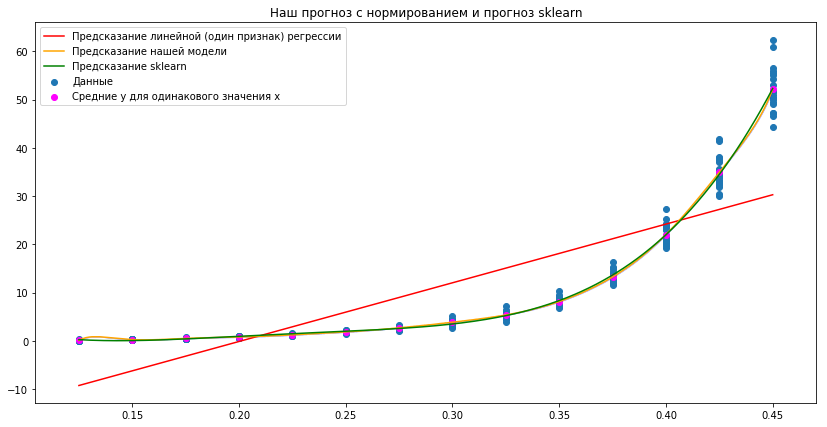

In [791]:
model = LinearAndGaussianProcessRegression(exp_cov, uniq=True)
model.fit(X.reshape((-1, 1)) / X.std(), y)
sklearn_model.fit(X.reshape((-1, 1)), y)

grid = np.linspace(X.min(), X.max(), 1000)
plt.figure(figsize=(14, 7))
plt.scatter(X, y, label="Данные")
plt.plot(grid, model.lr.predict(grid.reshape((-1, 1)) / X.std()),
         color="red", label="Предсказание линейной (один признак) регрессии")

plt.title("Наш прогноз с нормированием и прогноз sklearn")
plt.scatter(model.X_mean.ravel() * X.std(), model.y_mean.ravel(),
            color="magenta", label="Средние y для одинакового значения x")
#plt.scatter(X, model.predict(X.reshape((-1, 1))), color="red")
values, sigmas = model.full_predict(grid.reshape((-1, 1)) / X.std()) 
plt.plot(grid , values,
         color="orange", label="Предсказание нашей модели")
plt.plot(grid , sklearn_model.predict(grid.reshape((-1, 1))),
         color="green", label="Предсказание sklearn")
plt.fill_between(grid, values + 2 * sigmas, values - 2 * sigmas, 
                 color='blue', alpha=0.25)
# print(sigmas)
plt.legend()
plt.show()

#mean_squared_error(y, model.predict(X.reshape((-1, 1)) / X.std()))
#mean_squared_error(y, sklearn_model.predict(X.reshape((-1, 1)))) # отличаются на 0.05 в нашу пользу

Наш прогноз после нормирования почти не оnличается от прогноза sklearn. Посмотрим, что будет с законом из начала задания.

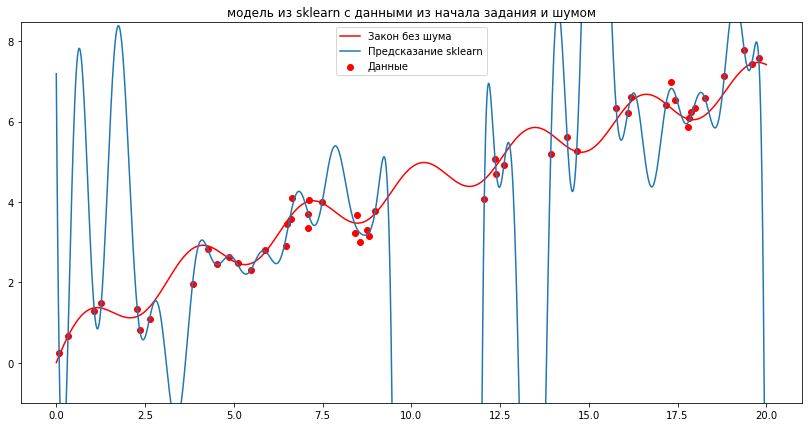

In [792]:
grid = np.linspace(0, 20, 1000)
real_function = np.array(list(map(calc_f, grid)))

T = uniform(loc=0, scale=20).rvs(size=50)
X = calc_f(T)
X += sps.norm(0, 0.3).rvs(X.shape)

sklearn_model = SKLearnGPR()
sklearn_model.fit(T.reshape((-1, 1)), X)

plt.figure(figsize=(14,7))
plt.plot(grid, real_function, color="red", label="Закон без шума")
plt.plot(grid, sklearn_model.predict(grid.reshape((-1, 1))), label="Предсказание sklearn")
plt.scatter(T, X, color="red", label="Данные")
plt.ylim((real_function.min() - 1, real_function.max() + 1))
plt.title("модель из sklearn c данными из начала задания и шумом")
plt.legend()
plt.show()

Знакомое поведение. Посмотрим, станет ли ей лучше, если мы вычтем прогноз линейной регрессии.

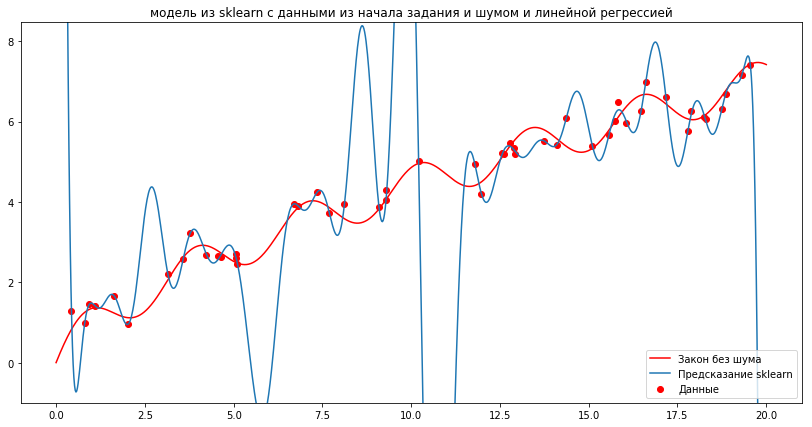

In [796]:
grid = np.linspace(0, 20, 1000)
real_function = np.array(list(map(calc_f, grid)))
lr = LinearRegression()
lr.fit(T.reshape((-1, 1)), X)

T = uniform(loc=0, scale=20).rvs(size=50)
X = calc_f(T)
X += sps.norm(0, 0.3).rvs(X.shape)

sklearn_model = SKLearnGPR()
sklearn_model.fit(T.reshape((-1, 1)), X - lr.predict(T.reshape((-1, 1))))

plt.figure(figsize=(14,7))
plt.plot(grid, real_function, color="red", label="Закон без шума")
plt.plot(grid, sklearn_model.predict(grid.reshape((-1, 1)))
         + lr.predict(grid.reshape((-1, 1))), label="Предсказание sklearn")
plt.scatter(T, X, color="red", label="Данные")
plt.ylim((real_function.min() - 1, real_function.max() + 1))
plt.title("модель из sklearn c данными из начала задания и шумом и линейной регрессией")
plt.legend()
plt.show()

Стало немного лучше. Ясно, что данный класс реализует базовый функционал и только его, считая, что обработка данных - качественно ручной процесс.

Напоследок, посмотрим, как она поведёт себя на данных без шума.

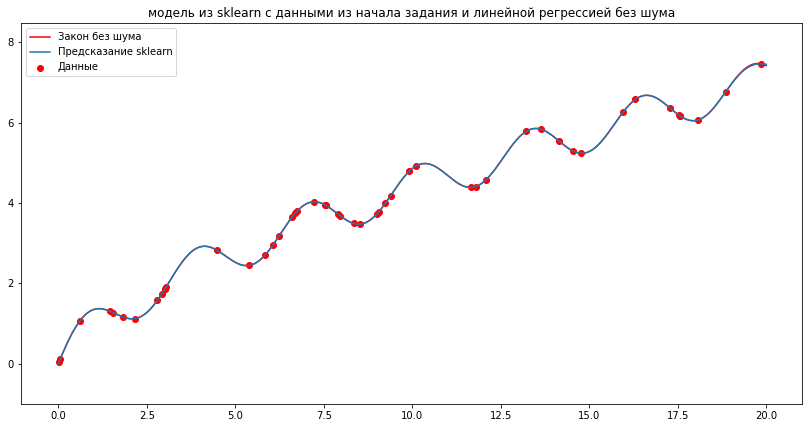

In [798]:
grid = np.linspace(0, 20, 1000)
real_function = np.array(list(map(calc_f, grid)))
lr = LinearRegression()
lr.fit(T.reshape((-1, 1)), X)

T = uniform(loc=0, scale=20).rvs(size=50)
X = calc_f(T)
# X += sps.norm(0, 0.3).rvs(X.shape)

sklearn_model = SKLearnGPR()
sklearn_model.fit(T.reshape((-1, 1)), X - lr.predict(T.reshape((-1, 1))))

plt.figure(figsize=(14,7))
plt.plot(grid, real_function, color="red", label="Закон без шума")
plt.plot(grid, sklearn_model.predict(grid.reshape((-1, 1)))
         + lr.predict(grid.reshape((-1, 1))), label="Предсказание sklearn")
plt.scatter(T, X, color="red", label="Данные")
plt.ylim((real_function.min() - 1, real_function.max() + 1))
plt.title("модель из sklearn c данными из начала задания и линейной регрессией без шума")
plt.legend()
plt.show()

Она ведёт себя точно так же, как и реализованный нами базовый класс. (Отличие в том, что мы подгоняли параметры ядра вручную)